# A multi layer epithelium

Consisting of stacked 2D sheets


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tyssue
from tyssue import Sheet, MultiSheet, MultiSheetGeometry
from tyssue.dynamics import MultiSheetModel
from tyssue.dynamics import PlanarModel

from tyssue.draw.plt_draw import quick_edge_draw

from tyssue.core.generation import hexa_grid2d, from_2d_voronoi
from tyssue.utils.utils import spec_updater
from scipy.spatial import Voronoi
from tyssue.draw.vispy_draw import vp_view

import seaborn as sns


In [4]:
base_specs = tyssue.config.geometry.flat_sheet()



In [9]:
from scipy.interpolate import Rbf

In [10]:
Rbf?

In [11]:
specs = base_specs.copy()
specs['face']['layer'] = 0
specs['vert']['layer'] = 0
specs['vert']['depth'] = 0.0
specs['edge']['layer'] = 0

## Interpolation arguments
specs['settings']['interpolate'] = {'function': 'gaussian',
                                    'epsilon': 1e-4}


In [12]:
layer_args = [(24, 24, 1, 1, 0.4),
              (16, 16, 2, 2, 1),
              (24, 24, 1, 1, 0.4),
              (24, 24, 1, 1, 0.4)]
dz = 1.0

layer_datasets = []
for i, args in enumerate(layer_args):
    centers = hexa_grid2d(*args)
    data = from_2d_voronoi(Voronoi(centers))
    data['vert']['z'] = i * dz
    layer_datasets.append(data)


In [13]:
msheet = MultiSheet('more',
                    layer_datasets,
                    specs)

In [14]:

MultiSheetGeometry.update_all(msheet)


bbox = [[0, 25], [0, 25]]

for sheet in msheet:
    edge_out = sheet.cut_out(bbox, coords=['x', 'y'])
    sheet.remove(edge_out)


In [15]:
print([np.all(np.isfinite(sheet.edge_df[sheet.dcoords])) for sheet in msheet])
print([np.all(np.isfinite(sheet.vert_df[sheet.coords])) for sheet in msheet])
print([np.all(np.isfinite(sheet.face_df[sheet.coords])) for sheet in msheet])

[True, True, True, True]
[True, True, True, True]
[True, True, True, True]


In [22]:
palette = sns.color_palette("Set1", n_colors=len(msheet), desat=.5)


In [23]:
for p in palette:
    print(p)

(0.69607843644917011, 0.30000000260770321, 0.30392157100141015)
(0.34198770274718604, 0.48141100064796549, 0.59391389223290425)
(0.39618994070618763, 0.58570167033695708, 0.390522889909791)
(0.53537487589261112, 0.38903115575804437, 0.55080740057370248)


In [30]:
def msheet_view(msheet, phi, psi, theta, ax=None, **kwargs):

    palette = sns.color_palette("Set1", n_colors=len(msheet), desat=.5)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    cos_psi = np.cos(psi)
    sin_psi = np.sin(psi)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation = np.array([[cos_psi*cos_phi - sin_psi*cos_theta*sin_phi,
                          -cos_psi*sin_phi - sin_psi*cos_theta*cos_phi,
                          sin_psi*sin_theta],
                         [sin_psi*cos_phi + cos_psi*cos_theta*sin_phi,
                          -sin_psi*sin_phi + cos_psi*cos_theta*cos_phi,
                          -cos_psi*sin_theta],
                         [sin_theta*sin_phi,
                          sin_theta*cos_phi,
                          cos_theta]])
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    for sheet, color in zip(msheet, palette):
 
        rotated = np.dot(sheet.vert_df[sheet.coords], rotation)
        sheet.vert_df['rx'] = rotated[:, 0]
        sheet.vert_df['ry'] = rotated[:, 1]
        sheet.edge_df['drx'] = (sheet.upcast_trgt(sheet.vert_df['rx'])
                                - sheet.upcast_srce(sheet.vert_df['rx']))
        sheet.edge_df['dry'] = (sheet.upcast_trgt(sheet.vert_df['ry'])
                                - sheet.upcast_srce(sheet.vert_df['ry']))
        
        fig, ax = quick_edge_draw(sheet, coords=['rx', 'ry'], ax=ax, c=color, **kwargs)
    return fig, ax

(-12, 0)

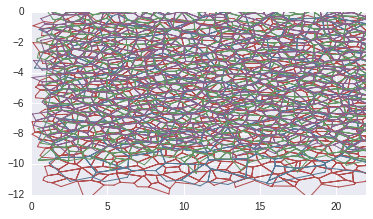

In [37]:
%matplotlib inline
fig, ax = msheet_view(msheet, psi=0, phi=0, 
                      theta=2*np.pi/3, ax=None, linewidth=1)
ax.set_xlim(0, 22)
ax.set_ylim(-12, 0)

In [38]:
mod_specs = {
    'edge': {
        'anchor_tension': 0.12,
        'line_tension': 0.12
        },
     'face': {
        'contractility': 0.04,
        'prefered_area': 1.0,
        'prefered_vol': 0.0,
        'area_elasticity': 1.0
        },
     'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0
        },
     'vert': {
        'radial_tension': 0.0,
        'prefered_height': 1.0,
        'd_elasticity': 1.0}}

layers_mod_specs = [
    {'face': {'prefered_area': 1.}},
    {'face': {'prefered_area': 4.}},
    {'face': {'prefered_area': 1.}},
    {'face': {'prefered_area': 1.}}]

for sheet, spec in zip(msheet, 
                       layers_mod_specs):
    
    spec_updater(mod_specs, spec)
    sheet.update_specs(MultiSheetModel.dimentionalize(mod_specs),
                       reset=True)


KeyError: 'u_elasticity'

In [65]:
MultiSheetModel.compute_energy(msheet)

15505.21227620382

In [70]:
%pdb

Automatic pdb calling has been turned ON


In [67]:
grads = MultiSheetModel.compute_gradient(msheet)

In [68]:
[np.all(np.isfinite(grad)) for grad in grads]

[True, True, True, True]

In [69]:
from scipy import optimize
from tyssue.solvers.sheet_vertex_solver import Solver

class MultiSheetSolver(Solver):
    
    @classmethod
    def find_energy_min(cls, msheet, geom,
                        model, pos_idxs, **settings_kw):
        settings = tyssue.config.solvers.minimize_spec()
        settings.update(**settings_kw)
        
        pos0 = [sheet.vert_df.loc[pos_idx, sheet.coords].values.flatten()
                for sheet, pos_idx in zip(msheet, pos_idxs)]
        
        max_length = 2 * msheet[0].edge_df['length'].max()
        pos0 = np.concatenate(pos0)
        bounds = np.vstack([pos0 - max_length,
                            pos0 + max_length]).T

        res = optimize.minimize(cls.opt_energy, pos0,
                        args=(pos_idxs, msheet, geom, model),
                        jac=cls.opt_grad, bounds=bounds,
                        **settings['minimize'])

        
        
    @staticmethod 
    def set_pos(pos, pos_idxs, msheet):
        v_idxs = np.array([pos_idx.shape[0] for 
                           pos_idx in pos_idxs]).cumsum()
        for sheet, pos_chunk, pos_idx in zip(msheet, np.split(pos, v_idxs[:-1]*3), pos_idxs):
            sheet.vert_df.loc[pos_idx, sheet.coords] = pos_chunk.reshape((pos_chunk.size//3, 3))
            
    @staticmethod
    def opt_grad(pos, pos_idxs, msheet, geom, model):
        grads = model.compute_gradient(msheet, components=False)
        grad_i = np.concatenate([grad.loc[pos_idx].values.flatten()
                                 for grad, pos_idx
                                 in zip(grads, pos_idxs)])
        return grad_i

    
    @classmethod
    def check_grad(cls, msheet, geom, model):

        pos_idxs = [sheet.vert_df[sheet.vert_df['is_active']==1].index
                    for sheet in msheet]
        pos0 = [sheet.vert_df.loc[pos_idx, sheet.coords].values.flatten()
                for sheet, pos_idx in zip(msheet, pos_idxs)]
        
        pos0 = np.concatenate(pos0)

        grad_err = optimize.check_grad(cls.opt_energy,
                                       cls.opt_grad,
                                       pos0,
                                       pos_idxs,
                                       msheet, geom, model)
        return grad_err


In [70]:
pos_idxs = [sheet.vert_df[sheet.vert_df['is_active']==1].index
            for sheet in msheet]
MultiSheetSolver.find_energy_min(msheet, MultiSheetGeometry,
                                 MultiSheetModel, pos_idxs)

In [100]:
grp_sheet = Sheet('grped',
                  msheet.concat_datasets(),
                  msheet[0].specs)

vp_view(grp_sheet)

In [98]:
def gauss2d(x, y, x0, y0, A, wx, wy):
    
    return A * (np.exp(-((x - x0)**2) / wx**2)
                * np.exp(-((y - y0)**2) / wy**2))

msheet[0].vert_df['basal_shift'] = gauss2d(
    msheet[0].vert_df['x'],
    msheet[0].vert_df['y'],
    x0=10, y0=10, A=4.1,
    wx=4, wy=3) - 1

MultiSheetGeometry.update_all(msheet)

In [99]:
MultiSheetSolver.find_energy_min(msheet, MultiSheetGeometry,
                                 MultiSheetModel, pos_idxs)

In [33]:
MultiSheetGeometry.update_all(msheet)

In [43]:
MultiSheetSolver.check_grad(msheet, MultiSheetGeometry,
                            MultiSheetModel)

4.3860634859906682